## Usage of the fundus_image_toolbox

In [1]:
from matplotlib import pyplot as plt
from fundus_image_toolbox.utilities import show, print_type

The vessel segmentation folder is missing. Downloading it from https://github.com/berenslab/MIDL24-segmentation_quality_control...


Cloning into '/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/fundus_image_toolbox/vessel_segmentation/segmentation'...
Updating files: 100% (28/28), done.
Already on 'main'


Your branch is up to date with 'origin/main'.
HEAD is now at 995a173 Update README.md
Adjusting imports...
########
 model_definition.py
########
 notebook_utils.py
/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/fundus_image_toolbox/vessel_segmentation/segmentation/utils
parents:  ['utils', 'model_definition']
imports:  ['FR_UNet']
/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/fundus_image_toolbox/vessel_segmentation/segmentation/models
parents:  ['models', 'model_utils']
imports:  ['dice_metric']
########
 model_utils.py
########
 frunet.py
########
 datasets.py
/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/fundus_image_toolbox/vessel_segmentation/segmentation/utils
parents:  ['utils', 'notebook_utils']
imports:  ['clahe_equalized']
Done.


/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


First, load some images to work with

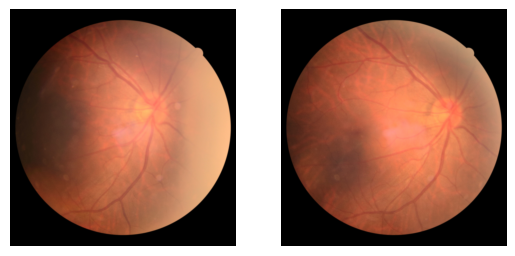

Type: <class 'numpy.ndarray'>
Shape: (1824, 1736, 3)
Type: uint8

Type: <class 'numpy.ndarray'>
Shape: (1824, 1736, 3)
Type: uint8



In [2]:
fundus1 = plt.imread('./imgs/fundus1.jpg')
fundus2 = plt.imread('./imgs/fundus2.jpg')

show([fundus1, fundus2])
print_type([fundus1, fundus2])

Note: When asked for a `device`, pass `'cpu'` to run the model(s) on your CPU or `'cuda:<x>'` for GPU usage (where `<x>` is the index of the GPU you want to use).

### Circle crop and center a fundus image

In [3]:
from fundus_image_toolbox.circle_crop import crop

In [4]:
# Crop the image. `image` can be a path to a file or a numpy array or torch tensor
fundus1_cropped = crop(fundus1, size=(512,512))
fundus2_cropped = crop(fundus2, size=(512,512))

show([fundus1_cropped, fundus2_cropped])
print_type([fundus1_cropped, fundus2_cropped])

Type: <class 'numpy.ndarray'>
Shape: (512, 512, 3)
Type: uint8

Type: <class 'numpy.ndarray'>
Shape: (512, 512, 3)
Type: uint8



### Predict fovea and optic disc coordinates

In [5]:
from fundus_image_toolbox.fovea_od_localization import load_fovea_od_model, plot_coordinates

In [6]:
device = "cpu"
model, checkpoint_path = load_fovea_od_model(checkpoint_dir="default", device=device, return_test_dataloader=False)
# predict from batch (could pass a single image, too)
coordinates = model.predict([fundus1, fundus2])
print("\nCoordinates (fovea_x, fovea_y, od_x, od_y):\n", coordinates)

Initializing efficientnet-b3 on cpu
Loading model from /Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/fundus_image_toolbox/fovea_od_localization/models/2024-05-07 11_13.05/multi_efficientnet-b3_best.pt
Default model 2024-05-07 11_13.05 not found, downloading...
Extracting weights...
Removing tar file...
Done

Coordinates (fovea_x, fovea_y, od_x, od_y):
 [array([ 607.59143,  894.26843, 1091.1732 ,  773.30756], dtype=float32), array([ 628.9441 ,  939.20734, 1279.766  ,  810.58325], dtype=float32)]


In [7]:
plot_coordinates([fundus1, fundus2], coordinates)

### Predict the quality (gradeability) of a fundus image

In [8]:
from fundus_image_toolbox.quality_prediction import load_quality_ensemble, ensemble_predict_quality, plot_quality

In [9]:
device = "cpu"

# Threshold for the quality prediction: Values below this threshold are considered as bad quality
threshold = 0.25

In [10]:
quality_ensemble = load_quality_ensemble(device=device)

At least one model was not found.


Downloading: 100%|██████████| 954M/954M [04:50<00:00, 3.45MB/s]  


Extracting weights...
Removing tar file...
Done
Model loaded from 2024-05-03 15-52-56
Model loaded from 2024-05-03 16-23-29
Model loaded from 2024-05-06 20-25-14
Model loaded from 2024-05-03 14-38-34
Model loaded from 2024-05-03 15-04-29
Model loaded from 2024-05-03 14-58-37
Model loaded from 2024-05-03 15-59-31
Model loaded from 2024-05-03 14-25-19
Model loaded from 2024-05-03 14-25-42
Model loaded from 2024-05-03 15-28-00


In [11]:
# Predict quality of the fundus images. Could pass a single image, too.
confs, labels = ensemble_predict_quality(quality_ensemble, [fundus1, fundus2], threshold=threshold)

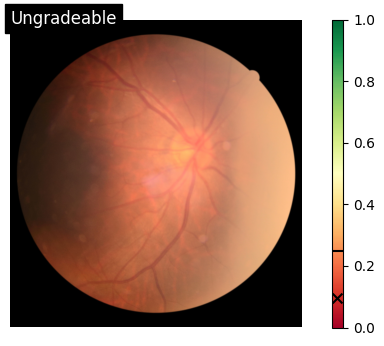

In [12]:
# Plot the quality of the fundus images (red: bad quality, green: good quality, x: model prediction, -: threshold)
plot_quality(fundus1, confs[0], labels[0], threshold)
plot_quality(fundus2, confs[1], labels[1], threshold)

### Register fundus images

In [13]:
from fundus_image_toolbox.registration import load_registration_model, register, DEFAULT_CONFIG

In [14]:
config = DEFAULT_CONFIG

# Change if desired, like: 
config['device'] = 'cpu'
display(config)

{'device': 'cpu',
 'use_matching_trick': True,
 'nms_size': 1,
 'nms_thresh': 0.0005,
 'knn_thresh': 0.85}

In [15]:
model, matcher = load_registration_model(config)

moving_image_aligned = register(
    fundus1, 
    fundus2, 
    show=True, 
    show_mapping=False, 
    config=config, 
    model=model, 
    matcher=matcher
)

Done


/Users/ziweih/.pyenv/versions/miniconda3-latest/envs/fundus_image_toolbox/lib/python3.9/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


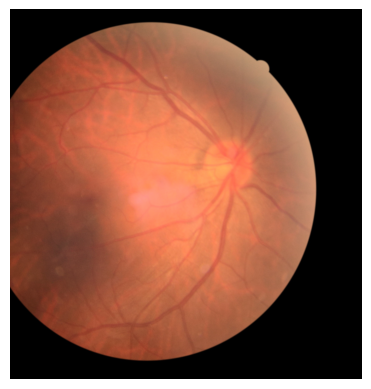

In [16]:
# Output: The moving image aligned to the fixed image
show(moving_image_aligned)

In [17]:
print_type(moving_image_aligned)

Type: <class 'numpy.ndarray'>
Shape: (1824, 1736, 3)
Type: uint8



### Segment the blood vessels in a fundus image

In [18]:
from fundus_image_toolbox.vessel_segmentation import load_segmentation_ensemble, ensemble_predict_segmentation, plot_masks

In [19]:
device = "cpu"

In [20]:
segmentation_ensemble = load_segmentation_ensemble(device=device)
vessel_masks = ensemble_predict_segmentation(segmentation_ensemble, [fundus1, fundus2], threshold=0.5)

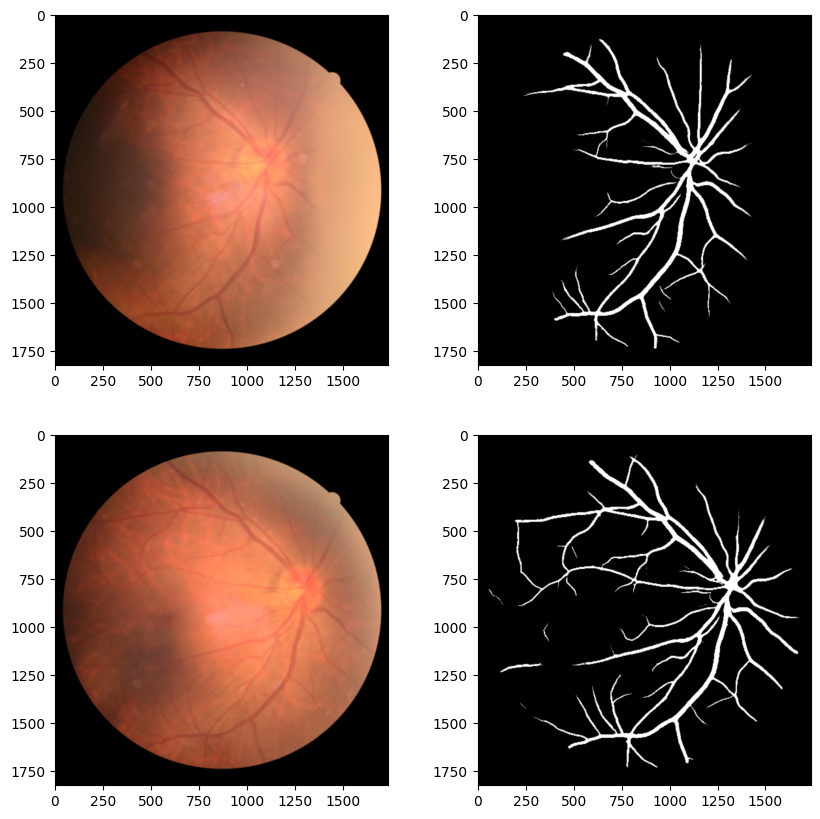

In [21]:
plot_masks([fundus1, fundus2], vessel_masks)

In [22]:
print_type(vessel_masks[0])
print_type(vessel_masks[1])

Type: <class 'numpy.ndarray'>
Shape: (1824, 1736)
Type: float64

Type: <class 'numpy.ndarray'>
Shape: (1824, 1736)
Type: float64

